In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import RNN, Dense, Layer
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.framework import tensor_shape
from tensorflow import float32, concat, convert_to_tensor

2023-06-15 17:25:30.646632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 17:25:30.703985: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-15 17:25:31.718595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class EulerIntegratorCell(Layer):
    def __init__(self, f_layer, y0=None, units=1, **kwargs):
        super(EulerIntegratorCell, self).__init__(**kwargs)
        self.units = units
        self.f_layer = f_layer
        self.y0 = y0
        self.state_size = tensor_shape.TensorShape(self.units)
        self.output_size = tensor_shape.TensorShape(self.units)

    def call(self, inputs, states):
        inputs = convert_to_tensor(inputs)
        y_tm1 = convert_to_tensor(states)
        dy_t = self.f_layer(inputs)
        y_t = dy_t + y_tm1[0, :]
        return y_t, [y_t]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.y0

In [4]:
def create_model(f_layer, y0, batch_input_shape, return_sequences=False, return_state=False):
    euler = EulerIntegratorCell(f_layer=f_layer, y0=y0, batch_input_shape=batch_input_shape)
    PINN = RNN(cell=euler, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=return_state)
    model = Sequential()
    model.add(PINN)
    model.compile(loss='mse', optimizer=RMSprop(1e-2))
    return model

In [5]:
if __name__ == "__main__":
    # Create synthetic data
    x_train = np.linspace(0, 2 * np.pi, 100)
    y_train = np.sin(x_train)

    x_train = x_train.reshape(-1, 1, 1)
    y_train = y_train.reshape(-1, 1)

    # Create f_layer to model f(x) = cos(x)
    f_layer = Sequential()
    f_layer.add(Dense(10, activation='tanh', input_shape=(1,)))
    f_layer.add(Dense(1))

    # Train f_layer to learn f(x) = cos(x)
    x_f_train = np.random.uniform(0, 2 * np.pi, 1000)
    y_f_train = np.cos(x_f_train)
    f_layer.compile(loss='mse', optimizer=RMSprop(1e-2))
    f_layer.fit(x_f_train, y_f_train, epochs=100)

    # Create the model
    y0 = np.zeros((x_train.shape[0], 1))
    model = create_model(f_layer=f_layer, y0=convert_to_tensor(y0, dtype=float32), batch_input_shape=x_train.shape)

    # Predict y before training
    y_pred_before = model.predict_on_batch(x_train)

    # Train the model
    model.fit(x_train, y_train, epochs=100, steps_per_epoch=1)

    # Predict y after training
    y_pred_after = model.predict_on_batch(x_train)

Epoch 1/100


2023-06-15 17:26:20.181151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


32/32 [==============================] - 0s 2ms/step - loss: 0.3790
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.2555
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1899
Epoch 4/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1406
Epoch 5/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1016
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0719
Epoch 7/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 8/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 9/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0388
Epoch 10/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 0.0335
Epoch 12/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 13/100
32/32 [=============================

2023-06-15 17:26:25.378982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,1,1]
	 [[{{node Placeholder/_0}}]]


Epoch 1/100
1/1 [==============================] - 1s 803ms/step - loss: 0.9615
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6555
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6428
Epoch 4/100
1/1 [==============================] - 0s 5ms/step - loss: 0.4921
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 0.4134
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3552
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.3120
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2752
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2438
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.2163
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 0.1924
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.1716
Epoch 13/100
1/1 [==============================] - 0s 5ms/

2023-06-15 17:26:27.339327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,1,1]
	 [[{{node Placeholder/_0}}]]


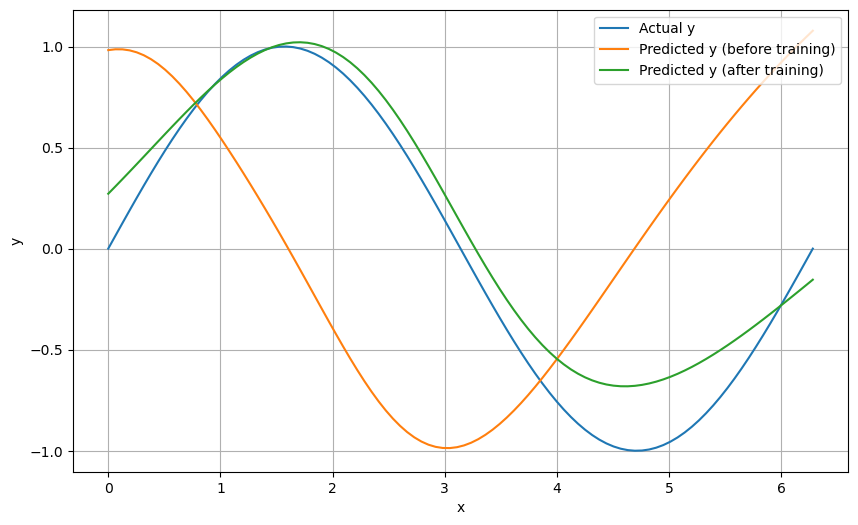

In [10]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_train[:, 0, 0], y_train[:, 0], '-', label='Actual y')
plt.plot(x_train[:, 0, 0], y_pred_before[:, 0], '-', label='Predicted y (before training)')
plt.plot(x_train[:, 0, 0], y_pred_after[:, 0], '-', label='Predicted y (after training)')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper right', facecolor='w')
plt.grid(which='both')
plt.show()

In [18]:
class EulerIntegratorCellDecay(Layer):
    def __init__(self, decay_constant, units=1, **kwargs):
        super(EulerIntegratorCellDecay, self).__init__(**kwargs)
        self.units = units
        self.decay_constant = decay_constant
        self.state_size = tensor_shape.TensorShape(self.units)
        self.output_size = tensor_shape.TensorShape(self.units)

    def build(self, input_shape, **kwargs):
        self.built = True

    def call(self, inputs, states):
        N_tm1 = convert_to_tensor(states)
        dN_t = -self.decay_constant * N_tm1[0, :]
        N = dN_t + N_tm1[0, :]
        return N, [N]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return self.initial_state

In [19]:
def create_model_decay(decay_constant, N0, batch_input_shape, return_sequences=False, return_state=False):
    euler_decay = EulerIntegratorCellDecay(decay_constant=decay_constant, batch_input_shape=batch_input_shape)
    euler_decay.initial_state = N0
    PINN_decay = RNN(cell=euler_decay, batch_input_shape=batch_input_shape, return_sequences=return_sequences, return_state=return_state)
    model = Sequential()
    model.add(PINN_decay)
    model.compile(loss='mse', optimizer=RMSprop(1e-2))
    return model

In [23]:
if __name__ == "__main__":
    # Decay constant
    decay_constant = 0.1

    # Time data
    time_data = np.linspace(0, 10, 100)[:, np.newaxis]
    time_data = time_data.reshape(1, -1, 1)

    # Initial number of radioactive atoms
    N0 = np.array([1000])

    # Analytical solution
    N_analytical = (N0 * np.exp(-decay_constant * time_data[0])).reshape(1, -1, 1)

    # Create and fit the PINN model
    model = create_model_decay(decay_constant=decay_constant, N0=convert_to_tensor(N0, dtype=float32), batch_input_shape=time_data.shape)
    N_pred_before = model.predict_on_batch(time_data).flatten()
    model.fit(time_data, N_analytical, epochs=100, steps_per_epoch=1, verbose=1)
    N_pred = model.predict_on_batch(time_data).flatten()


Epoch 1/100


2023-06-15 18:18:47.248843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,100,1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 168ms/step - loss: 433666.6875
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 433666.6875
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 433666.6875
Epoch 4/100
1/1 [==============================] - 0s 8ms/step - loss: 433666.6875
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 433666.6875
Epoch 6/100
1/1 [==============================] - 0s 8ms/step - loss: 433666.6875
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 433666.6875
Epoch 8/100
1/1 [==============================] - 0s 9ms/step - loss: 433666.6875
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 433666.6875
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 433666.6875
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 433666.6875
Epoch 12/100
1/1 [==============================] - 0s 9ms/step - loss: 433666.6875
Epoch 13/1

2023-06-15 18:18:48.841023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1,100,1]
	 [[{{node Placeholder/_0}}]]


ValueError: x and y must have same first dimension, but have shapes (100, 1) and (1,)

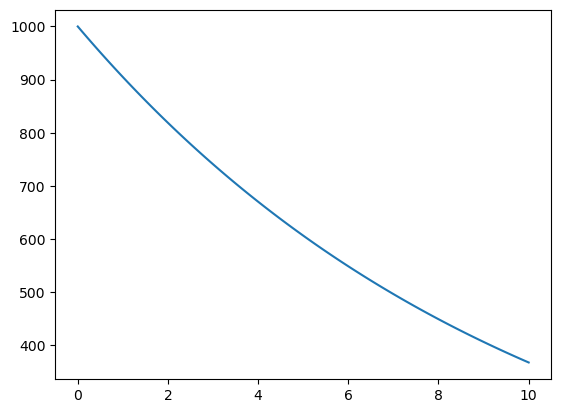

In [31]:
    fig = plt.figure()
    plt.plot(time_data[0], N_analytical[0, :, 0], label="Analytical solution")
    plt.plot(time_data[0], N_pred_before[0,], 'o', label="PINN prediction before training")
    plt.plot(time_data[0], N_pred, 's', label="PINN prediction after training")
    plt.xlabel("Time")
    plt.ylabel("Number of radioactive atoms")
    plt.legend(loc="upper right", facecolor="w")
    plt.grid(which="both")
    plt.show()